# 1: Import Libraries

In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# 2: Load and Preprocess Dataset

In [16]:
# Load and preprocess the dataset
excel_path = '/kaggle/input/cvrpro/19MDVRP Problem Sets.xlsx'  # Update with the actual dataset path
data = pd.read_excel(excel_path, sheet_name='Problem 1')

# Extract customer and depot information
customers = data[['Customer Number', 'x coordinate', 'y coordinate']].dropna()
depots = data[['Depot x coordinate', 'Depot y coordinate']].dropna()

# Add random demands for customers
np.random.seed(42)
customers['Demand'] = np.random.randint(1, 10, size=len(customers))

# Define vehicle capacity
VEHICLE_CAPACITY = 50

# Display the data
print("Customers:\n", customers.head())
print("Depots:\n", depots.head())

Customers:
    Customer Number  x coordinate  y coordinate  Demand
0                1            37            52       7
1                2            49            49       4
2                3            52            64       8
3                4            20            26       5
4                5            40            30       7
Depots:
    Depot x coordinate  Depot y coordinate
0                20.0                20.0
1                30.0                40.0
2                50.0                30.0
3                60.0                50.0


# 3: Define the Environment

In [17]:
# Define the delivery environment
class DeliveryEnvironment:
    def __init__(self, customers, depots, vehicle_capacity):
        self.customers = customers
        self.depots = depots
        self.vehicle_capacity = vehicle_capacity
        self.num_customers = len(customers)
        self.reset()

    def reset(self):
        self.current_position = self.depots.iloc[0][['Depot x coordinate', 'Depot y coordinate']].to_numpy()
        self.remaining_load = self.vehicle_capacity
        self.visited = set()
        self.total_distance = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        state = {
            'current_position': self.current_position,
            'remaining_load': self.remaining_load,
            'unvisited_customers': [
                (i, row['x coordinate'], row['y coordinate'], row['Demand'])
                for i, row in self.customers.iterrows() if i not in self.visited
            ]
        }
        return state

    def step(self, action):
        if action in self.visited:
            return None, -10, self.done  # Penalty for invalid action

        customer = self.customers.iloc[action]
        demand = customer['Demand']
        distance = np.linalg.norm(self.current_position - customer[['x coordinate', 'y coordinate']].to_numpy())

        if self.remaining_load < demand:
            return None, -10, self.done  # Penalty for overload

        # Update state
        self.visited.add(action)
        self.remaining_load -= demand
        self.current_position = customer[['x coordinate', 'y coordinate']].to_numpy()
        self.total_distance += distance

        # Check if all customers are visited
        self.done = len(self.visited) == self.num_customers
        reward = -distance  # Negative distance as reward (minimize total distance)
        return self._get_state(), reward, self.done

# 4: Define the Policy Network

In [18]:
# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# 5: Train the Policy Network

In [19]:
# Step 5: Train the Policy Network
def train_policy_network(env, policy_net, optimizer, num_episodes=1000):
    episode_rewards = []
    best_reward = float('-inf')
    best_policy_state = None
    num_customers = len(env.customers)
    
    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        log_probs = []
        rewards = []
        route = []

        while not env.done:
            # Prepare state tensor with padding for fixed input size
            customer_features = np.zeros((num_customers, 3))
            unvisited = state['unvisited_customers']
            
            if not unvisited:
                break
                
            for c in unvisited:
                customer_features[c[0]] = c[1:]  # Fill in unvisited customer data

            # Flatten state features
            state_features = np.concatenate([
                state['current_position'], 
                [state['remaining_load']], 
                customer_features.flatten()
            ])
            state_tensor = torch.tensor(state_features, dtype=torch.float32)

            # Get action probabilities
            action_probs = policy_net(state_tensor)
            valid_actions = [c[0] for c in unvisited]
            
            # Mask invalid actions
            action_mask = torch.zeros_like(action_probs)
            action_mask[valid_actions] = 1
            masked_probs = action_probs * action_mask
            masked_probs = masked_probs / (masked_probs.sum() + 1e-10)  # Renormalize

            # Sample action
            m = Categorical(masked_probs)
            action = m.sample().item()
            route.append(action)

            # Take action in the environment
            next_state, reward, done = env.step(action)
            
            episode_reward += reward
            log_probs.append(m.log_prob(torch.tensor(action)))
            rewards.append(reward)

            if done:
                break
                
            state = next_state

        # Save best policy
        if episode_reward > best_reward:
            best_reward = episode_reward
            best_policy_state = policy_net.state_dict()

        # Compute returns with baseline
        G = 0
        returns = []
        for r in reversed(rewards):
            G = r + 0.99 * G
            returns.insert(0, G)
        returns = torch.tensor(returns)
        
        # Normalize returns
        if len(returns) > 0:
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)

            # Compute policy loss with entropy regularization
            policy_loss = []
            entropy = []
            for log_prob, G in zip(log_probs, returns):
                policy_loss.append(-log_prob * G)
                entropy.append(-torch.exp(log_prob) * log_prob)
            
            policy_loss = torch.cat(policy_loss).sum()
            entropy_loss = torch.stack(entropy).sum()
            total_loss = policy_loss - 0.01 * entropy_loss  # Add entropy bonus

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)  # Gradient clipping
            optimizer.step()

        episode_rewards.append(episode_reward)
        
        if episode % 50 == 0:
            avg_reward = np.mean(episode_rewards[-50:]) if episode_rewards else episode_reward
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}, Best Reward: {best_reward:.2f}")
            print(f"Route: {route}")
            
    # Restore best policy
    if best_policy_state is not None:
        policy_net.load_state_dict(best_policy_state)
        
    return episode_rewards, best_reward

# 6: Initialize and Train

Episode 0: Reward = -1988.99, Avg = -1988.99
Route: [10, 17, 23, 35, 12, 26, 16, 22, 42, 8, 5, 33, 41, 11, 43, 48, 37, 4, 18, 21, 38, 31, 25, 34, 0, 9, 24, 28, 30, 32, 2, 46, 20, 39, 13, 6, 36, 15, 47, 40, 27, 44, 19, 14, 29, 7, 45, 49, 1, 3]
Episode 10: Reward = -1791.27, Avg = -1832.54
Route: [26, 11, 10, 22, 16, 23, 12, 24, 35, 37, 48, 43, 40, 30, 34, 8, 4, 42, 18, 2, 0, 21, 17, 5, 36, 46, 6, 41, 15, 27, 47, 45, 39, 28, 9, 14, 29, 33, 20, 3, 13, 49, 7, 38, 25, 31, 19, 32, 44, 1]
Episode 20: Reward = -1848.63, Avg = -1774.74
Route: [26, 35, 10, 12, 37, 16, 8, 24, 27, 43, 34, 49, 23, 11, 30, 42, 2, 17, 40, 32, 48, 4, 39, 9, 5, 46, 22, 18, 6, 45, 15, 19, 21, 0, 14, 41, 33, 47, 29, 31, 3, 1, 20, 13, 36, 25, 28, 44, 7, 38]
Episode 30: Reward = -1820.75, Avg = -1842.45
Route: [26, 10, 12, 35, 15, 24, 43, 40, 23, 8, 21, 11, 17, 49, 30, 34, 2, 14, 4, 9, 27, 18, 46, 22, 6, 39, 42, 5, 37, 33, 48, 0, 36, 19, 16, 32, 29, 31, 45, 25, 47, 1, 3, 20, 44, 28, 41, 13, 38, 7]
Episode 40: Reward = -176

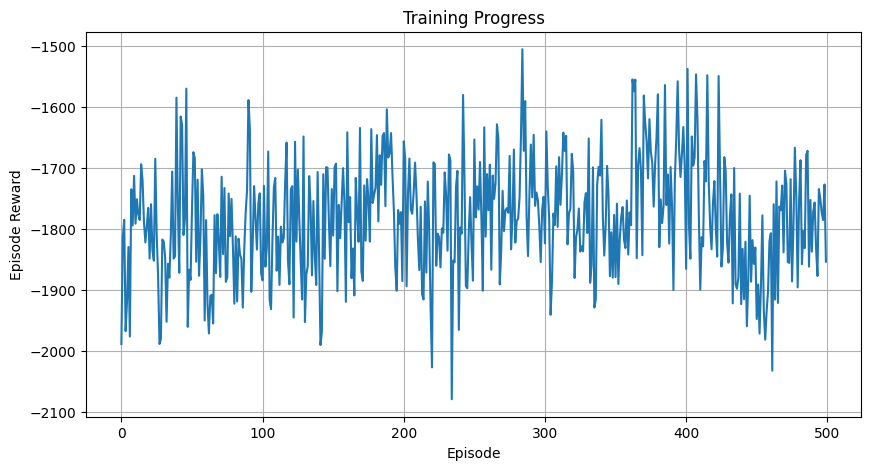


Training completed!
Best reward achieved: -1504.67


In [21]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

class DeliveryEnvironment:
    def __init__(self, customers, depots, vehicle_capacity):
        self.customers = customers
        self.depots = depots
        self.vehicle_capacity = vehicle_capacity
        self.num_customers = len(customers)
        self.initial_depot = depots.iloc[0][['Depot x coordinate', 'Depot y coordinate']].to_numpy()
        self.reset()

    def reset(self):
        self.current_position = self.initial_depot.copy()
        self.remaining_load = self.vehicle_capacity
        self.visited = set()
        self.total_distance = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        # Always return a valid state dictionary
        return {
            'current_position': self.current_position.copy(),
            'remaining_load': self.remaining_load,
            'unvisited_customers': [
                (i, row['x coordinate'], row['y coordinate'], row['Demand'])
                for i, row in self.customers.iterrows() if i not in self.visited
            ]
        }

    def step(self, action):
        try:
            # Handle invalid action
            if action in self.visited:
                return self._get_state(), -100, True  # End episode with penalty
            
            # Get customer info
            customer = self.customers.iloc[action]
            demand = customer['Demand']
            customer_pos = np.array([customer['x coordinate'], customer['y coordinate']])
            
            # Calculate distance to customer
            distance = np.linalg.norm(self.current_position - customer_pos)
            total_distance_delta = distance
            
            # Handle capacity constraint
            if self.remaining_load < demand:
                # Return to depot first
                depot_distance = np.linalg.norm(self.current_position - self.initial_depot)
                total_distance_delta += depot_distance
                self.current_position = self.initial_depot.copy()
                self.remaining_load = self.vehicle_capacity
            
            # Move to customer
            self.current_position = customer_pos.copy()
            self.remaining_load -= demand
            self.visited.add(action)
            
            # Check if done
            self.done = len(self.visited) == self.num_customers
            reward = -total_distance_delta  # Negative distance as reward
            
            return self._get_state(), reward, self.done
            
        except Exception as e:
            print(f"Error in step function: {str(e)}")
            # Return current state with penalty instead of None
            return self._get_state(), -100, True

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

def train_policy_network(env, policy_net, optimizer, num_episodes=500):
    episode_rewards = []
    best_reward = float('-inf')
    best_policy = None
    num_customers = len(env.customers)

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        log_probs = []
        rewards = []
        route = []

        try:
            while not env.done:
                # Prepare state features
                customer_features = np.zeros((num_customers, 3))
                unvisited = state['unvisited_customers']
                
                if not unvisited:
                    break
                    
                for c in unvisited:
                    customer_features[c[0]] = c[1:]

                # Create state tensor
                state_tensor = torch.tensor(
                    np.concatenate([
                        state['current_position'],
                        [state['remaining_load']],
                        customer_features.flatten()
                    ]),
                    dtype=torch.float32
                )

                # Get logits
                logits = policy_net(state_tensor)

                # Create and apply action mask
                valid_actions = [c[0] for c in unvisited]
                action_mask = torch.zeros_like(logits)
                action_mask[valid_actions] = 1

                # Apply mask with numerical stability
                masked_logits = logits - logits.max()  # For numerical stability
                masked_logits = masked_logits * action_mask
                masked_logits[action_mask == 0] = float('-inf')

                # Compute probabilities
                probs = torch.nn.functional.softmax(masked_logits, dim=0)

                # Ensure valid probability distribution
                if torch.isnan(probs).any() or torch.isinf(probs).any():
                    probs = torch.zeros_like(logits)
                    probs[valid_actions] = 1.0 / len(valid_actions)

                # Sample action
                m = Categorical(probs)
                action = m.sample().item()
                route.append(action)

                # Take action
                next_state, reward, done = env.step(action)
                
                if next_state is None:
                    print("Warning: received None state")
                    break

                log_probs.append(m.log_prob(torch.tensor(action)))
                rewards.append(reward)
                episode_reward += reward

                if done:
                    break

                state = next_state

        except Exception as e:
            print(f"Error in episode {episode}: {str(e)}")
            continue

        # Update policy if we have valid rewards
        if rewards:
            # Calculate returns
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + 0.99 * G
                returns.insert(0, G)
            returns = torch.tensor(returns)

            # Normalize returns
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-8)

            # Calculate loss
            policy_loss = []
            for log_prob, G in zip(log_probs, returns):
                policy_loss.append(-log_prob * G)

            policy_loss = torch.stack(policy_loss).sum()

            # Backprop
            optimizer.zero_grad()
            policy_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
            optimizer.step()

        # Track best policy
        if episode_reward > best_reward:
            best_reward = episode_reward
            best_policy = policy_net.state_dict()

        episode_rewards.append(episode_reward)

        if episode % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
            print(f"Episode {episode}: Reward = {episode_reward:.2f}, Avg = {avg_reward:.2f}")
            print(f"Route: {route}")

    return episode_rewards, best_reward, best_policy

def run_training():
    try:
        # Initialize environment
        env = DeliveryEnvironment(customers, depots, VEHICLE_CAPACITY)
        num_customers = len(customers)
        
        # Initialize network
        input_dim = 2 + 1 + 3 * num_customers
        policy_net = PolicyNetwork(
            input_dim=input_dim,
            hidden_dim=128,
            output_dim=num_customers
        )
        
        # Initialize optimizer
        optimizer = optim.Adam(policy_net.parameters(), lr=0.0005)
        
        # Train
        rewards_history, best_reward, best_policy = train_policy_network(
            env=env,
            policy_net=policy_net,
            optimizer=optimizer
        )
        
        # Load best policy
        if best_policy is not None:
            policy_net.load_state_dict(best_policy)
        
        # Plot results
        plt.figure(figsize=(10, 5))
        plt.plot(rewards_history)
        plt.title('Training Progress')
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.grid(True)
        plt.show()
        
        print(f"\nTraining completed!")
        print(f"Best reward achieved: {best_reward:.2f}")
        
        return env, policy_net, rewards_history, best_reward
        
    except Exception as e:
        print(f"Error in training: {str(e)}")
        raise

# Run the training
env, trained_policy_net, rewards_history, best_reward = run_training()

# 7: Visualize the Final Route

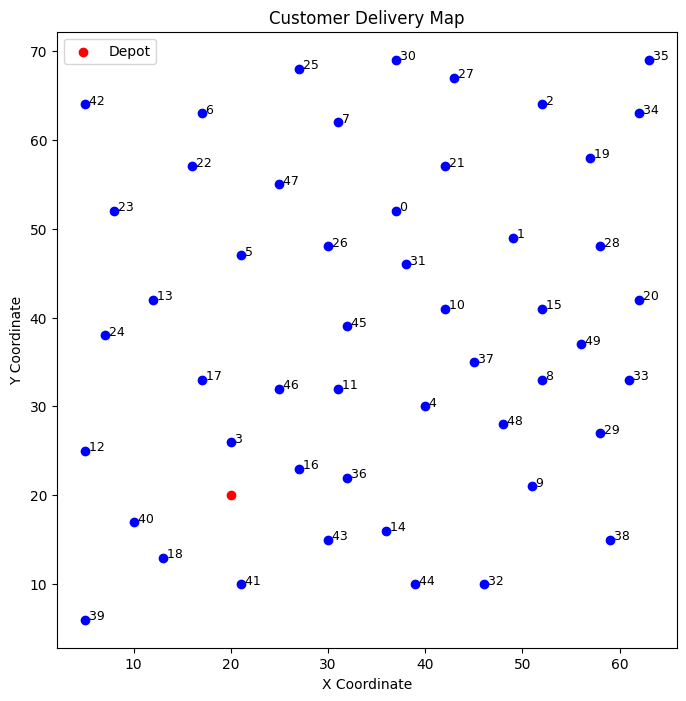

In [22]:
# Plot the final delivery route
plt.figure(figsize=(8, 8))
for i, row in customers.iterrows():
    plt.scatter(row['x coordinate'], row['y coordinate'], c='blue')
    plt.text(row['x coordinate'], row['y coordinate'], f" {i}", fontsize=9)
plt.scatter(depots.iloc[0]['Depot x coordinate'], depots.iloc[0]['Depot y coordinate'], c='red', label='Depot')
plt.title('Customer Delivery Map')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()